In this project, we will classify medical images of different body parts using the deep learning multi layer perceptron (MLP) model with tensorflow and analyse how accurately it can classify the images. This dataset has been collected from [Kaggle](https://www.kaggle.com/datasets/andrewmvd/medical-mnist/data).

In order to do that, let's import all the relevant libraries, i.e, numpy and pandas first.

In [43]:
import numpy as np
import pandas as pd

## Exploratory data analysis and visualization.
Now we need to load the data and do little bit of investigation. This dataset has 5 categories of medical data corresponding to different body parts. 
1. Hand 
2. Breast
3. Head 
4. Abdomen
5. Chest
   
We will load the images and get a glimpse of some of these images:

In [2]:
import glob
data_path = '../datasets/med_dataset/*'  #dataset path

data_dirpaths = []
for dir in glob.glob(data_path):
    data_dirpaths.append(dir) #appending each category dataset path
print(data_dirpaths)

['../datasets/med_dataset/Hand', '../datasets/med_dataset/BreastMRI', '../datasets/med_dataset/HeadCT', '../datasets/med_dataset/AbdomenCT', '../datasets/med_dataset/CXR']


So there are 5 directories containing the images for each category. Now let's go to each cateogory and collect their filenames and category and write into a pandas dataframe

In [3]:
import os
image_files = [] # list to store image file paths
category = [] # List to store image categories
cat_name = ['hand', 'breast', 'head', 'abdomen', 'chest']
for i, data_dirpath in enumerate(data_dirpaths):
    data_dirpath += '/*.jpeg'
    print(data_dirpath)
    image_files_cat = sorted(glob.glob(data_dirpath))
    cat_len = len(image_files_cat)
    image_files += image_files_cat
    category += [cat_name[i]]*cat_len

print(f"Number of image files: {len(image_files)}")    
print(f" Length of category items : {len(category)}")

# Write everything to a pandas dicitonary
dict = {'image_file_paths' : image_files, 'category': category}
df = pd.DataFrame(dict)

../datasets/med_dataset/Hand/*.jpeg
../datasets/med_dataset/BreastMRI/*.jpeg
../datasets/med_dataset/HeadCT/*.jpeg
../datasets/med_dataset/AbdomenCT/*.jpeg
../datasets/med_dataset/CXR/*.jpeg
Number of image files: 48954
 Length of category items : 48954


In [4]:
df.head()

,image_file_paths,category
0,../datasets/med_dataset/Hand/000000.jpeg,hand
1,../datasets/med_dataset/Hand/000001.jpeg,hand
2,../datasets/med_dataset/Hand/000002.jpeg,hand
3,../datasets/med_dataset/Hand/000003.jpeg,hand
4,../datasets/med_dataset/Hand/000004.jpeg,hand


In [5]:
df.describe()

,image_file_paths,category
count,48954,48954
unique,48954,5
top,../datasets/med_dataset/Hand/000000.jpeg,hand
freq,1,10000


In [6]:
df['category'].value_counts()

category
hand       10000
head       10000
abdomen    10000
chest      10000
breast      8954
Name: count, dtype: int64

As we can see there are 10000 images in each category except the breast category which has 8954 images in it.

Let's try to read some of the images and visualize them.

(64, 64)


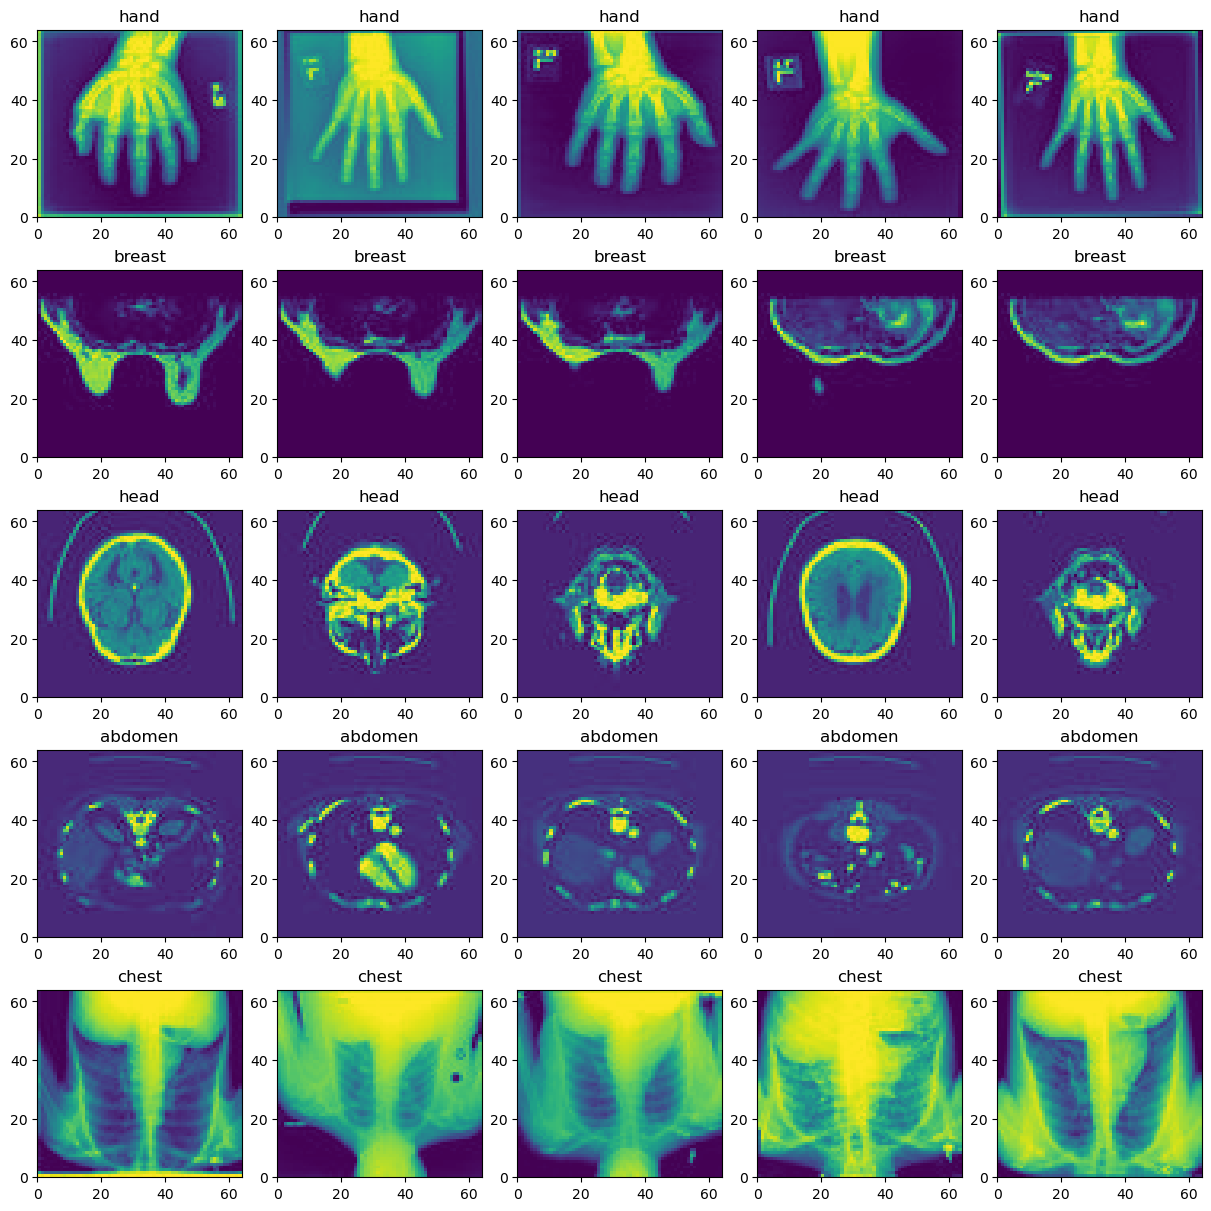

In [7]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5,5, constrained_layout=True, figsize = (12,12))
for i in range(5):
    cat = cat_name[i]
    read_files = list(df[df['category'] == cat]['image_file_paths'][:5])
    for j in range(5):
        img = mpimg.imread(read_files[j])
        #print(img.shape)
        axs[i,j].pcolormesh(img)
        axs[i,j].set_title(cat)
print(img.shape)
plt.show()

## Train, validation and test splitting
The plot shows the different categories of medical images. Each image is 60 by 60 pixel == 3600 features when the 2D array is flattened.

The hand, abdomen, chest and breast has more or less same features while the head images vary a lot. Before modelling the data, we need to shuffle the data and split it into train, validation and test set. 

In [8]:
#shuffling and returning all the data
df_new = df.sample(frac = 1)

#Let's convert the categorical values into numerical values
df_new['category'].replace(cat_name, [0, 1, 2, 3, 4], inplace=True)
df_new.head()

,image_file_paths,category
35216,../datasets/med_dataset/AbdomenCT/006262.jpeg,3
4731,../datasets/med_dataset/Hand/004731.jpeg,0
12097,../datasets/med_dataset/BreastMRI/002097.jpeg,1
15922,../datasets/med_dataset/BreastMRI/005922.jpeg,1
44129,../datasets/med_dataset/CXR/005175.jpeg,4


In [9]:
from sklearn.model_selection import train_test_split

# Split into train and test first
data_train, data_test = train_test_split(df_new, test_size = 0.2, random_state = 0)

# Split the test into test and validate again
data_val, data_test = train_test_split(data_test, test_size = 0.5, random_state = 0)
print(f" Train data shape : {data_train.shape}, Test data shape : {data_test.shape}, Validation data shape: {data_val.shape}")

 Train data shape : (39163, 2), Test data shape : (4896, 2), Validation data shape: (4895, 2)


Now before modelling, we need to load the data from all the image into a numpy array

In [10]:
X_train = np.zeros((data_train.shape[0], 64, 64))
y_train = np.array(data_train['category']).reshape(-1, 1)

print(y_train.shape)

X_val = np.zeros((data_val.shape[0], 64, 64))
y_val = np.array(data_val['category']).reshape(-1, 1)

X_test = np.zeros((data_test.shape[0], 64, 64))
y_test = np.array(data_test['category']).reshape(-1, 1)

(39163, 1)


In [11]:
#Now let's read the images and fill in the training dataset:
# training data
print("Starting to collect data from images")
for i,filepath_train in enumerate(list(data_train['image_file_paths'])):
    img_array = mpimg.imread(filepath_train)
    X_train[i,:,:] = img_array

# validation data
for j,filepath_val in enumerate(list(data_val['image_file_paths'])):
    img_array = mpimg.imread(filepath_val)
    X_val[j,:,:] = img_array

# testing data
for k,filepath_test in enumerate(list(data_test['image_file_paths'])):
    img_array = mpimg.imread(filepath_test)
    X_test[k,:,:] = img_array
print("Finished collecting images")

Starting to collect data from images
Finished collecting images


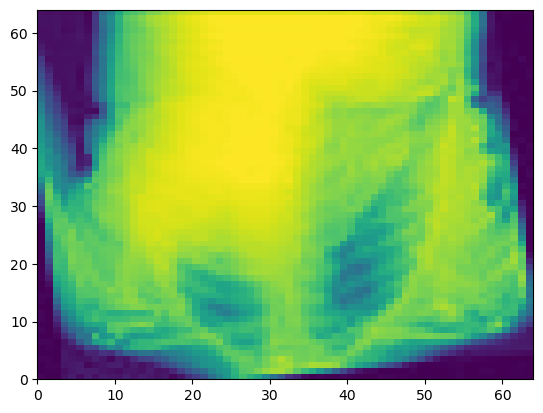

In [12]:
#plotting a random image to test it
plt.pcolormesh(X_train[100,:,:])
plt.show()

## Model building with Tensorflow
Now let's build a Multi Layer Perceptron model with tensorflow.
The input layer will flatten the array values giving 4096 features. Let's build 2 hidden layers, first with 25 units and second with 15 units, and at the end we will have an output layer with 5 units. We will keep the relu activation units for the hidden layers. In principal we could use softmax regression unit for the output layers. In tensorflow it is better recommended to keep the output layers linear and calculate probabilities of each class later in order to avoid round off errors.

We will also use Flatten layer to flatten the array into a one dimensional array. Using Sequential function, we can connect multiple Dense layers as a deep neural network. Depending the performance of this model, we can build complex models later on.


In [13]:
# load the tensorflow libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Let's build the model

tf.random.set_seed(42) # Set the random seed to get same reproducable results
model1 = Sequential([
        Flatten(input_shape=[64, 64]), 
        Dense(25, activation="relu", name = 'layer1'),
        Dense(15, activation="relu", name = 'layer2'),
        Dense(5, activation="linear", name = 'layer3')
])

2024-03-03 11:05:29.109766: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


The first hidden layer will have ((4096 weights)+ 1 bias term) * 25 neural units = 102425 parameters

The second hidden layer will have ((25 weights) + 1 bias term) * 15 neural units = 390 parameters

layer 3 will have ((15 weights) + 1 bias term) * 5 neural units = 80 parameters

Total trainable parameters = 102895 

Let's look at the model summary:

In [14]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 layer1 (Dense)              (None, 25)                102425    
                                                                 
 layer2 (Dense)              (None, 15)                390       
                                                                 
 layer3 (Dense)              (None, 5)                 80        
                                                                 
Total params: 102,895
Trainable params: 102,895
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Get layer information
model1.layers

In [16]:
# Get each layers
[layer1, layer2, layer3, layer4] = model1.layers

# Get each layer parameters
w1, b1 = layer2.get_weights()
print(w1.shape, b1.shape)

#printing randomly initialized parameters of the first unit
print(w1[:10, 0])

(4096, 25) (25,)
[ 0.03718509 -0.03264963 -0.0291921  -0.01611849  0.02815713 -0.00749494
 -0.00720541 -0.01886297 -0.02774192 -0.02373393]


## Model compiling and training
Since we set the activation function of the output layers to be linear, we need to do logits = True while compiling the model. Also we will use the 
sparse_categorical_crossentropy loss function and Adam optimizer for choosing the learning rate for optimizing the cost function. Adam optimizer can adjust the the learning rate of each model parameter adaptively depending on how the cost function changes.

In [17]:
model1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
               metrics = ["accuracy"])

In [18]:
history1 = model1.fit(X_train, y_train, epochs = 30)

Epoch 1/30
1224/1224 [==============================] - 2s 1ms/step - loss: 1.6338 - accuracy: 0.9414
Epoch 2/30
1224/1224 [==============================] - 1s 1ms/step - loss: 0.5145 - accuracy: 0.9694
Epoch 3/30
1224/1224 [==============================] - 1s 1ms/step - loss: 0.4143 - accuracy: 0.9669
Epoch 4/30
1224/1224 [==============================] - 1s 1ms/step - loss: 0.3451 - accuracy: 0.9672
Epoch 5/30
1224/1224 [==============================] - 1s 1ms/step - loss: 0.3340 - accuracy: 0.9571
Epoch 6/30
1224/1224 [==============================] - 1s 1ms/step - loss: 0.2520 - accuracy: 0.9635
Epoch 7/30
1224/1224 [==============================] - 1s 1ms/step - loss: 0.1902 - accuracy: 0.9704
Epoch 8/30
1224/1224 [==============================] - 1s 1ms/step - loss: 0.1744 - accuracy: 0.9738
Epoch 9/30
1224/1224 [==============================] - 1s 1ms/step - loss: 0.1694 - accuracy: 0.9739
Epoch 10/30
1224/1224 [==============================] - 1s 1ms/step - loss: 0.126

At a time the model is trained in batches of 32 images and each time the model goes through 1224 batches to train the data. As we can see we are seeing a 95 % accuracy in the training set

Let's look at the prediciton of the model on the training dataset first.

In [21]:
#Get the linear value from the mode
logits = model1(X_train)
pred_train = tf.nn.softmax(logits) # this basically gives the probability of each class
y_pred_train = np.argmax(pred_train, axis = 1)
#print(y_pred_train.shape)
for i in range(50):
    print(y_train[i], y_pred_train[i]) # returns the index of maximum probability == cateogory

(39163,)
[2] 2
[4] 4
[0] 0
[0] 0
[0] 0
[1] 1
[4] 4
[3] 3
[2] 2
[2] 2
[0] 0
[0] 0
[3] 3
[3] 3
[3] 3
[4] 4
[0] 0
[1] 1
[3] 3
[3] 3
[0] 0
[4] 4
[1] 1
[2] 2
[3] 3
[4] 4
[4] 4
[2] 2
[0] 0
[3] 3
[0] 0
[4] 4
[3] 3
[3] 3
[0] 0
[2] 2
[1] 1
[2] 2
[3] 3
[3] 3
[4] 4
[0] 0
[0] 3
[4] 4
[2] 2
[0] 0
[3] 3
[1] 1
[2] 2
[1] 1


## Evaluation of the model and prediction errors.

At least in the 50 cases we have listed above, the prediction of category and actual category matches pretty well. Let's look at number of cases when predictions failed.

In [38]:
error_ind_train = np.where((y_train[:,0] != y_pred_train))[0] # error condidtion
good_ind_train = np.where((y_train[:,0] == y_pred_train))[0]
print(len(error_ind_train), len(good_ind_train), len(y_train))
error_train = len(error_ind_train)/len(y_train)
print(f"Error level in % : {error_train * 100.0}")

312 38851 39163
Error level in % : 0.7966703265837652


The error level is only 0.8 % or 99.2% accuracy in the training data. Let's see how the model performs with the validation data.

In [35]:
# Calculating the error for the validation dataset
#Get the linear value from the model
logits_val = model1.predict(X_val)
pred_val = tf.nn.softmax(logits_val) # this basically gives the probability of each class
y_pred_val = np.argmax(pred_val, axis = 1)

# Calculate the validation error
error_ind_val = np.where((y_val[:,0] != y_pred_val))[0] # error condidtion
good_ind_val = np.where((y_val[:,0] == y_pred_val))[0]
print(len(error_ind_val), len(good_ind_val), len(y_val))
error_val = len(error_ind_val)/len(y_val)
print(f"Error level in % : {error_val * 100.0}")

153/153 [==============================] - 0s 490us/step
42 4853 4895
Error level in % : 0.8580183861082737


In [37]:
# Calculating the error for the test dataset
#Get the linear value from the model
logits_test = model1.predict(X_test)
pred_test = tf.nn.softmax(logits_test) # this basically gives the probability of each class
y_pred_test = np.argmax(pred_test, axis = 1)

# Calculate the validation error
error_ind_test = np.where((y_test[:,0] != y_pred_test))[0] # error condidtion
good_ind_test = np.where((y_test[:,0] == y_pred_test))[0]
print(len(error_ind_test), len(good_ind_test), len(y_test))
error_test = len(error_ind_test)/len(y_test)
print(f"Error level in % : {error_test * 100.0}")

153/153 [==============================] - 0s 521us/step
48 4848 4896
Error level in % : 0.9803921568627451


The current MLP model is giving a **99 % accuracy in the classifying the medical images which is great.** Now let's look at the 48 misclassified images and why it might have happened.

This was our category: ('hand': 0, 'breast': 1, 'head': 2, 'abdomen': 3, 'chest':4]

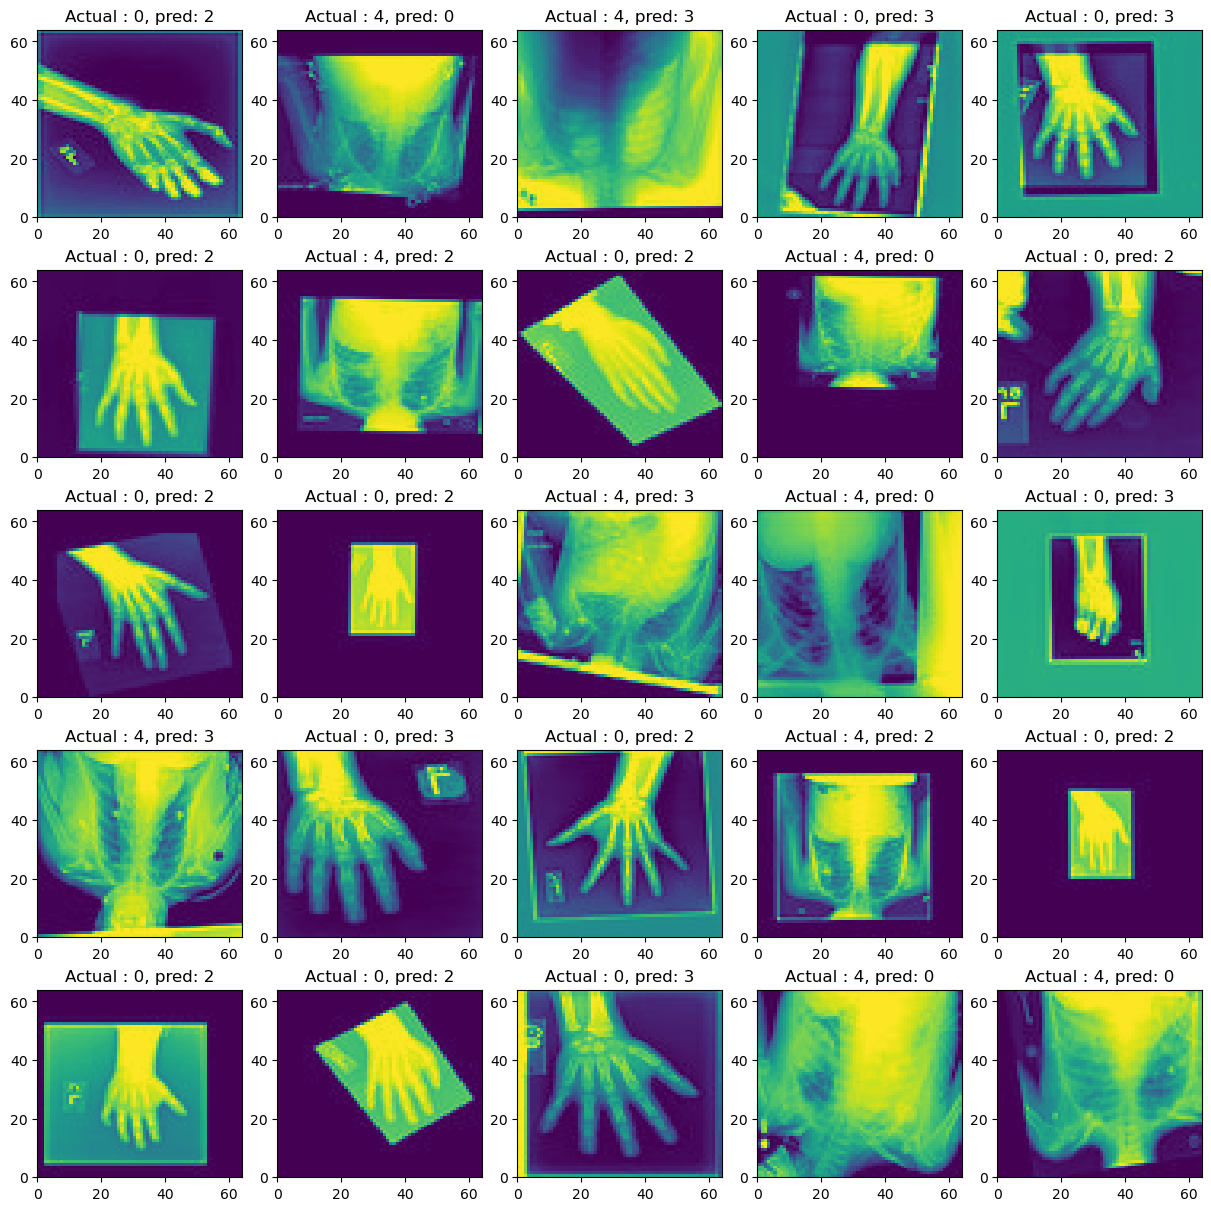

In [39]:
# Plotting the first 25 of the misclassified images:

fig, axs = plt.subplots(5,5, constrained_layout=True, figsize = (12,12))
for i in range(5):
    for j in range(5):
        num = i*5+j
        ind = error_ind_test[num]
        img = X_test[ind,:,:]
        axs[i,j].pcolormesh(img)
        axs[i,j].set_title(f"Actual : {y_test[ind,0]}, pred: {y_pred_test[ind]}")
plt.show()

Interestingly, what we can see is that in most of the misclassified cases are from chest and hand images. Most of these images are zoomed out or zoomed in versions and appears translated in pixel space. The MLP model is finding hard to classify the wonky images which looks different from the normal class of images showed earlier.

Also, let's look at how these sparse categorical loss and accuracy changes over iteration epochs.

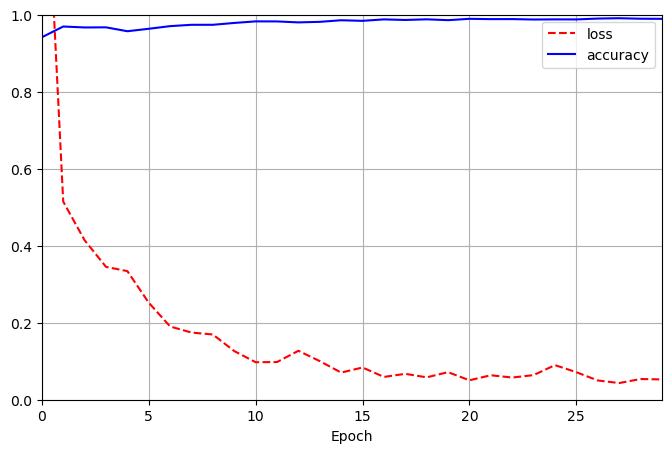

In [42]:
# plotting the loss and accuracy
pd.DataFrame(history1.history).plot(
figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch", style=["r--", "b-"])
plt.show()

Let's build a little more complex model with 3 hidden layers and more units and see if it can detect features from wonky images:

In [49]:
# Building more complex model

tf.random.set_seed(50) # Set the random seed to get same reproducable results
model2 = Sequential([
        Flatten(input_shape=[64, 64]), 
        Dense(50, activation="relu", name = 'layer1'),
        Dense(25, activation="relu", name = 'layer2'),
        Dense(15, activation="relu", name = 'layer3'),
        Dense(5, activation="linear", name = 'layer4')
])

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 4096)              0         
                                                                 
 layer1 (Dense)              (None, 50)                204850    
                                                                 
 layer2 (Dense)              (None, 25)                1275      
                                                                 
 layer3 (Dense)              (None, 15)                390       
                                                                 
 layer4 (Dense)              (None, 5)                 80        
                                                                 
Total params: 206,595
Trainable params: 206,595
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Compiling and fitting the data
model2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
               metrics = ["accuracy"])

history2 = model2.fit(X_train, y_train, epochs = 40)

Epoch 1/40
1224/1224 [==============================] - 2s 1ms/step - loss: 0.9437 - accuracy: 0.9348
Epoch 2/40
1224/1224 [==============================] - 2s 1ms/step - loss: 0.2467 - accuracy: 0.9652
Epoch 3/40
1224/1224 [==============================] - 2s 1ms/step - loss: 0.3672 - accuracy: 0.9023
Epoch 4/40
1224/1224 [==============================] - 2s 1ms/step - loss: 0.1907 - accuracy: 0.9608
Epoch 5/40
1224/1224 [==============================] - 2s 1ms/step - loss: 0.1524 - accuracy: 0.9678
Epoch 6/40
1224/1224 [==============================] - 2s 1ms/step - loss: 0.1818 - accuracy: 0.9619
Epoch 7/40
1224/1224 [==============================] - 2s 1ms/step - loss: 0.1422 - accuracy: 0.9705
Epoch 8/40
1224/1224 [==============================] - 2s 1ms/step - loss: 0.2277 - accuracy: 0.9564
Epoch 9/40
1224/1224 [==============================] - 2s 1ms/step - loss: 0.2205 - accuracy: 0.9547
Epoch 10/40
1224/1224 [==============================] - 2s 1ms/step - loss: 0.145

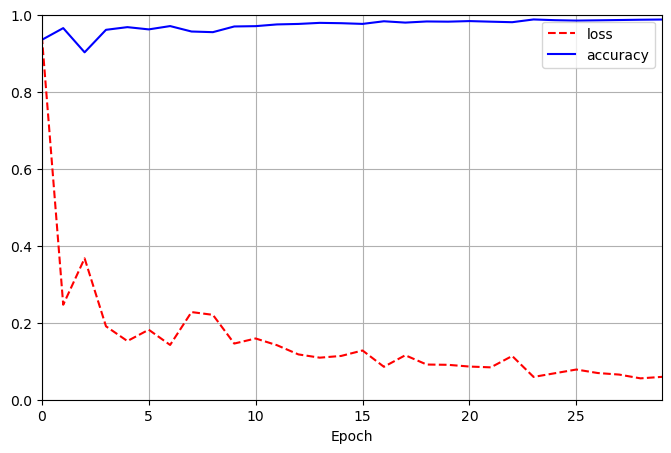

In [51]:
# plotting the loss and accuracy
pd.DataFrame(history2.history).plot(
figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch", style=["r--", "b-"])
plt.show()

In [52]:
# Now let's looks at the training, validation and test erros with the new model

###### Training error ################
#Get the linear value from the model
logits = model2(X_train)
pred_train = tf.nn.softmax(logits) # this basically gives the probability of each class
y_pred_train = np.argmax(pred_train, axis = 1)

error_ind_train = np.where((y_train[:,0] != y_pred_train))[0] # error condidtion
good_ind_train = np.where((y_train[:,0] == y_pred_train))[0]
print(len(error_ind_train), len(good_ind_train), len(y_train))
error_train = len(error_ind_train)/len(y_train)
print(f" Train error level in % : {error_train * 100.0}")

### Validation Error ##########
# Calculating the error for the validation dataset
#Get the linear value from the model
logits_val = model2.predict(X_val)
pred_val = tf.nn.softmax(logits_val) # this basically gives the probability of each class
y_pred_val = np.argmax(pred_val, axis = 1)

# Calculate the validation error
error_ind_val = np.where((y_val[:,0] != y_pred_val))[0] # error condidtion
good_ind_val = np.where((y_val[:,0] == y_pred_val))[0]
print(len(error_ind_val), len(good_ind_val), len(y_val))
error_val = len(error_ind_val)/len(y_val)
print(f" Validation Error level in % : {error_val * 100.0}")

##### Test error ########
#Get the linear value from the model
logits_test = model2.predict(X_test)
pred_test = tf.nn.softmax(logits_test) # this basically gives the probability of each class
y_pred_test = np.argmax(pred_test, axis = 1)

# Calculate the validation error
error_ind_test = np.where((y_test[:,0] != y_pred_test))[0] # error condidtion
good_ind_test = np.where((y_test[:,0] == y_pred_test))[0]
print(len(error_ind_test), len(good_ind_test), len(y_test))
error_test = len(error_ind_test)/len(y_test)
print(f" Test error level in % : {error_test * 100.0}")

398 38765 39163
 Train error level in % : 1.0162653525010852
153/153 [==============================] - 0s 555us/step
60 4835 4895
 Validation Error level in % : 1.2257405515832482
153/153 [==============================] - 0s 569us/step
60 4836 4896
 Test error level in % : 1.2254901960784315


After making our model little more complex, the accuracy has gone down by 0.3 %. Looks like our first model is effiecient in identifying high level features compared to the second complex model.

However in order to identify space variant features, we might need to utilize a convolutional neural networks which are used for computer vision purposes. However being said that the ***the first MLP model does a good job in classifying images with 99 % accuray.***